In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_absolute_error
import shap
import joblib
import pickle

In [2]:
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Load data
df = pd.read_csv("HR Data.csv")
print(f"Raw Data Shape: {df.shape}")

Raw Data Shape: (1470, 41)


In [4]:
# Clean column names
df.columns = df.columns.str.strip()
df.head()

,Attrition,Business Travel,CF_age band,CF_attrition label,Department,Education Field,emp no,Employee Number,Gender,Job Role,...,Performance Rating,Relationship Satisfaction,Standard Hours,Stock Option Level,Total Working Years,Work Life Balance,Years At Company,Years In Current Role,Years Since Last Promotion,Years With Curr Manager
0,Yes,Travel_Rarely,35 - 44,Ex-Employees,Sales,Life Sciences,STAFF-1,1,Female,Sales Executive,...,3,1,80,0,8,1,6,4,0,5
1,No,Travel_Frequently,45 - 54,Current Employees,R&D,Life Sciences,STAFF-2,2,Male,Research Scientist,...,4,4,80,1,10,3,10,7,1,7
2,Yes,Travel_Rarely,35 - 44,Ex-Employees,R&D,Other,STAFF-4,4,Male,Laboratory Technician,...,3,2,80,0,7,3,0,0,0,0
3,No,Travel_Frequently,25 - 34,Current Employees,R&D,Life Sciences,STAFF-5,5,Female,Research Scientist,...,3,3,80,0,8,3,8,7,3,0
4,No,Travel_Rarely,25 - 34,Current Employees,R&D,Medical,STAFF-7,7,Male,Laboratory Technician,...,3,4,80,1,6,3,2,2,2,2


In [5]:
# Drop irrelevant/constant columns
drop_cols = ['Employee Count', 'Over18', 'Standard Hours', '-2', '0']
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

In [6]:
# Encode categorical variables
le_dict = {}
categorical_cols = ['Business Travel', 'Department', 'Education Field', 'Gender', 
                    'Job Role', 'Marital Status', 'Over Time', 'CF_age band', 
                    'CF_attrition label', 'Education']

for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        le_dict[col] = le

In [7]:
# Map Attrition
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

In [8]:
# Feature Engineering
df['Recent_Promotion'] = (df['Years Since Last Promotion'] == 0).astype(int)
df['High_OverTime'] = (df['Over Time'] == le_dict['Over Time'].transform(['Yes'])[0]).astype(int)

In [9]:
# Save processed
df.to_csv("hr_processed.csv", index=False)
print(f"Processed Data Shape: {df.shape}")

Processed Data Shape: (1470, 38)


## Task 1: Employee Attrition Prediction

In [10]:
# Features
attr_features = ['Age', 'Job Satisfaction', 'Over Time', 'Business Travel', 
                 'Monthly Income', 'Distance From Home', 'Job Role', 'Environment Satisfaction']

X = df[attr_features]
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# Scale
scaler_attr = StandardScaler()
X_train_s = scaler_attr.fit_transform(X_train)
X_test_s = scaler_attr.transform(X_test)

In [12]:
# Model
attr_model = LogisticRegression(random_state=42, max_iter=1000)
attr_model.fit(X_train_s, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [13]:
# Evaluate
y_pred = attr_model.predict(X_test_s)
acc = attr_model.score(X_test_s, y_test)
print(f"Attrition Model Accuracy: {acc:.3f}")
print(classification_report(y_test, y_pred))

Attrition Model Accuracy: 0.847
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       247
           1       0.55      0.23      0.33        47

    accuracy                           0.85       294
   macro avg       0.71      0.60      0.62       294
weighted avg       0.82      0.85      0.82       294



In [14]:
# Save
joblib.dump(attr_model, "attr_model.pkl")
joblib.dump(scaler_attr, "scaler_attr.pkl")

['scaler_attr.pkl']

In [15]:
import os

os.makedirs("charts", exist_ok=True) 

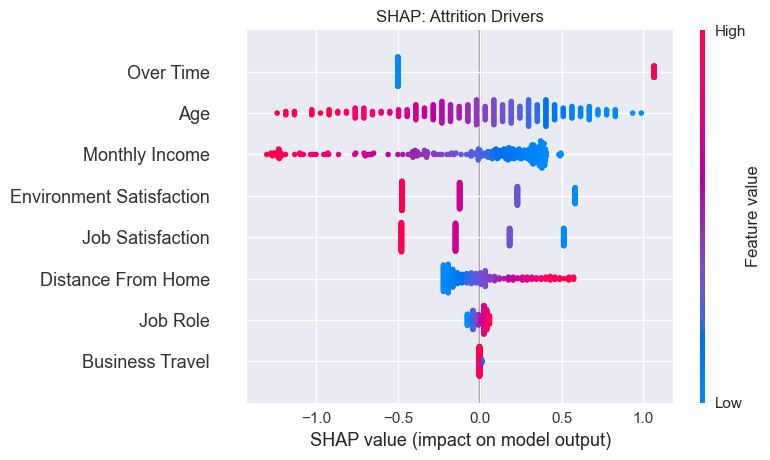

In [16]:
# SHAP
explainer = shap.LinearExplainer(attr_model, X_train_s)
shap_values = explainer.shap_values(X_test_s)
shap.summary_plot(shap_values, X_test_s, feature_names=attr_features, show=False)
plt.title("SHAP: Attrition Drivers")
plt.tight_layout()
plt.savefig("charts/shap_attrition.png")
plt.show()

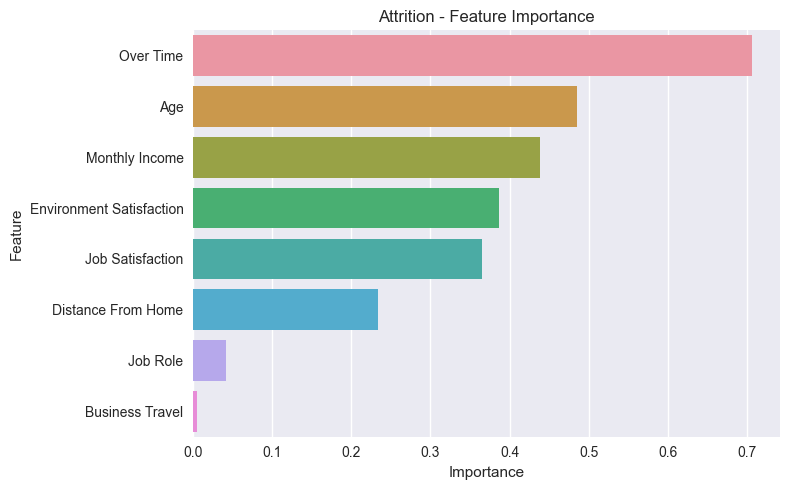

In [17]:
# Feature Importance
importances = pd.DataFrame({
    'Feature': attr_features,
    'Importance': np.abs(attr_model.coef_[0])
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=importances, x='Importance', y='Feature')
plt.title("Attrition - Feature Importance")
plt.tight_layout()
plt.savefig("charts/attrition_importance.png")
plt.show()

In [18]:
# KPI
attrition_rate = df['Attrition'].mean() * 100
print(f"Overall Attrition Rate: {attrition_rate:.1f}%")

Overall Attrition Rate: 16.1%


## Task 2: Performance Rating Forecasting

In [19]:
perf_features = ['Years At Company', 'Training Times Last Year', 'Job Involvement', 
                 'Job Level', 'Total Working Years']

X = df[perf_features]
y = df['Performance Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
perf_model = LinearRegression()
perf_model.fit(X_train, y_train)

LinearRegression()

In [21]:
y_pred = perf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Performance R²: {r2:.3f}, MAE: {mae:.3f}")

Performance R²: -0.030, MAE: 0.247


In [22]:
joblib.dump(perf_model, "perf_model.pkl")

['perf_model.pkl']

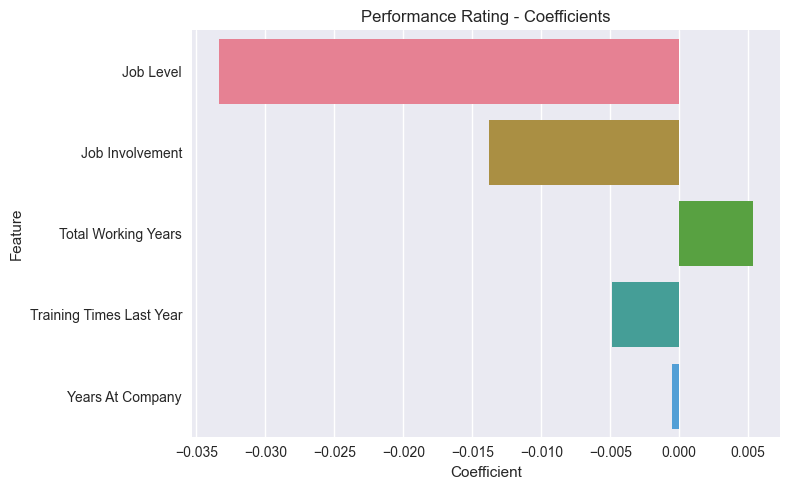

In [23]:
# Feature Importance
coeffs = pd.DataFrame({
    'Feature': perf_features,
    'Coefficient': perf_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=coeffs, x='Coefficient', y='Feature')
plt.title("Performance Rating - Coefficients")
plt.tight_layout()
plt.savefig("charts/perf_coeffs.png")
plt.show()

In [24]:
## Task 3: Salary Prediction

In [25]:
sal_features = ['Education', 'Job Level', 'Total Working Years', 'Performance Rating', 
                'Job Role', 'Years At Company', 'Stock Option Level']

X = df[sal_features]
y = df['Monthly Income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
scaler_sal = StandardScaler()
X_train_s = scaler_sal.fit_transform(X_train)
X_test_s = scaler_sal.transform(X_test)

In [27]:
sal_model = LinearRegression()
sal_model.fit(X_train_s, y_train)

LinearRegression()

In [28]:
y_pred = sal_model.predict(X_test_s)
r2 = r2_score(y_test, y_pred)
print(f"Salary R²: {r2:.3f}")

Salary R²: 0.907


In [29]:
joblib.dump(sal_model, "sal_model.pkl")
joblib.dump(scaler_sal, "sal_scaler.pkl")

['sal_scaler.pkl']

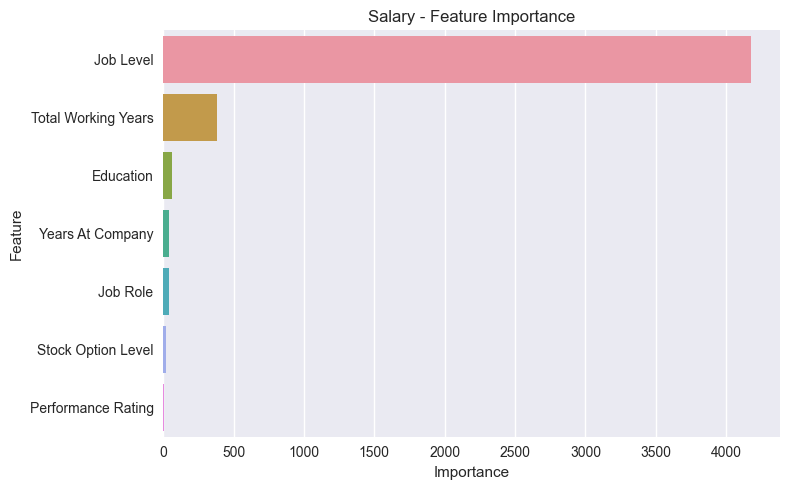

In [30]:
# Importance
importances = pd.DataFrame({
    'Feature': sal_features,
    'Importance': np.abs(sal_model.coef_)
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=importances, x='Importance', y='Feature')
plt.title("Salary - Feature Importance")
plt.tight_layout()
plt.savefig("charts/salary_importance.png")
plt.show()

## Task 4: Job Satisfaction Analysis

In [31]:
js_features = ['Environment Satisfaction', 'Relationship Satisfaction', 
               'Work Life Balance', 'Distance From Home', 'Job Involvement']

X = df[js_features]
y = df['Job Satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
js_model = LinearRegression()
js_model.fit(X_train, y_train)

LinearRegression()

In [33]:
r2 = r2_score(y_test, js_model.predict(X_test))
print(f"Job Satisfaction R²: {r2:.3f}")

Job Satisfaction R²: -0.029


In [34]:
joblib.dump(js_model, "js_model.pkl")

['js_model.pkl']

## Task 5: Promotion Likelihood

In [35]:
promo_features = ['Performance Rating', 'Job Level', 'Years In Current Role', 
                  'Total Working Years', 'Training Times Last Year']

X = df[promo_features]
y = df['Recent_Promotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [36]:
scaler_promo = StandardScaler()
X_train_s = scaler_promo.fit_transform(X_train)
X_test_s = scaler_promo.transform(X_test)

In [37]:
promo_model = LogisticRegression(random_state=42)
promo_model.fit(X_train_s, y_train)

LogisticRegression(random_state=42)

In [38]:
acc = promo_model.score(X_test_s, y_test)
print(f"Promotion Model Accuracy: {acc:.3f}")

Promotion Model Accuracy: 0.670


In [39]:
joblib.dump(promo_model, "promo_model.pkl")
joblib.dump(scaler_promo, "promo_scaler.pkl")

['promo_scaler.pkl']

## Task 6: Employee Clustering

In [40]:
cluster_features = ['CF_age band', 'Gender', 'Marital Status', 'Job Role', 
                    'Department', 'Monthly Income', 'Job Level']

X_cluster = df[cluster_features].copy()

In [41]:
# Encode if needed
for col in ['CF_age band', 'Gender', 'Marital Status', 'Job Role', 'Department']:
    if col in le_dict:
        X_cluster[col] = X_cluster[col].astype(str)
        known_classes = set(le_dict[col].classes_)
        X_cluster[col] = X_cluster[col].apply(
            lambda x: x if x in known_classes else list(known_classes)[0]
        )
        X_cluster[col] = le_dict[col].transform(X_cluster[col])

scaler_cluster = StandardScaler()
X_cluster_s = scaler_cluster.fit_transform(X_cluster)

In [42]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster_s)

In [43]:
joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(scaler_cluster, "cluster_scaler.pkl")

['cluster_scaler.pkl']

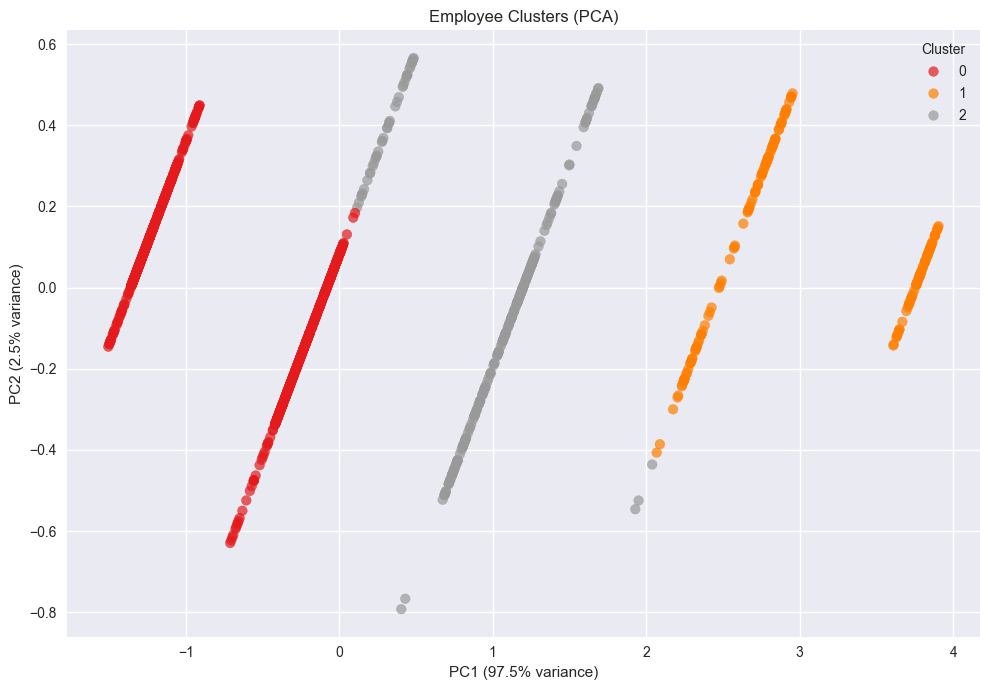

In [44]:
# PCA Visualization
from sklearn.decomposition import PCA
pca = PCA(2)
X_pca = pca.fit_transform(X_cluster_s)

plt.figure(figsize=(10,7))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df['Cluster'], cmap='Set1', alpha=0.7)
plt.title("Employee Clusters (PCA)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.savefig("charts/clusters.png")
plt.show()

In [45]:
# Cluster Profiles
cluster_profile = df.groupby('Cluster')[['Age', 'Monthly Income', 'Job Satisfaction']].mean()
print(cluster_profile)

               Age  Monthly Income  Job Satisfaction
Cluster                                             
0        34.527027     3943.764479          2.741313
1        47.529070    17054.959302          2.715116
2        39.438931     9695.099237          2.687023


## Task 7: Overtime Propensity Prediction

In [46]:
ot_features = ['Job Role', 'Department', 'Work Life Balance', 'Job Level', 'Monthly Income']

X = df[ot_features]
y = df['High_OverTime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [47]:
scaler_ot = StandardScaler()
X_train_s = scaler_ot.fit_transform(X_train)
X_test_s = scaler_ot.transform(X_test)

In [48]:
ot_model = LogisticRegression(random_state=42)
ot_model.fit(X_train_s, y_train)

LogisticRegression(random_state=42)

In [49]:
acc = ot_model.score(X_test_s, y_test)
print(f"Overtime Model Accuracy: {acc:.3f}")

Overtime Model Accuracy: 0.718


In [50]:
joblib.dump(ot_model, "ot_model.pkl")
joblib.dump(scaler_ot, "ot_scaler.pkl")

['ot_scaler.pkl']

## Task 8: Diversity & Inclusion Insights

In [51]:
# Decode for analysis
df_vis = df.copy()
for col, le in le_dict.items():
    if col in df_vis.columns:
        df_vis[col] = le.inverse_transform(df_vis[col])

In [52]:
# Gender by Department
gender_dept = pd.crosstab(df_vis['Department'], df_vis['Gender'])
print(gender_dept)

Gender      Female  Male
Department              
HR              20    43
R&D            379   582
Sales          189   257


<Figure size 1000x600 with 0 Axes>

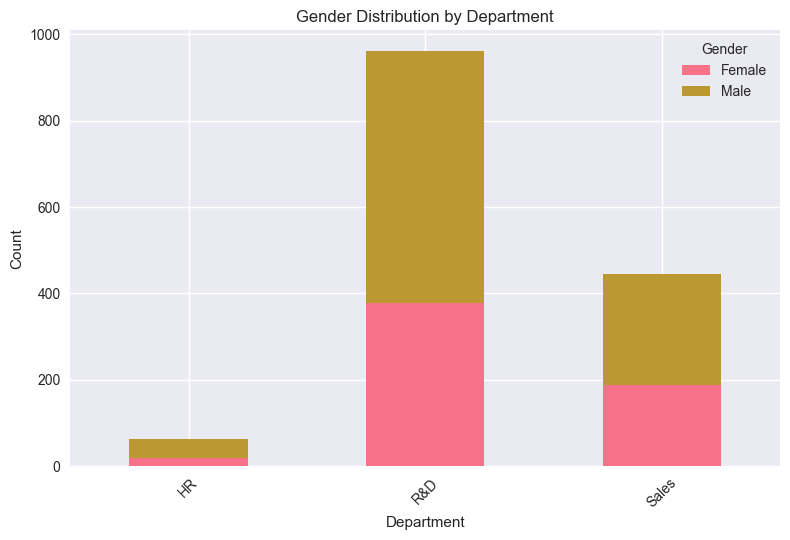

In [53]:
plt.figure(figsize=(10,6))
gender_dept.plot(kind='bar', stacked=True)
plt.title("Gender Distribution by Department")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("charts/gender_dept.png")
plt.show()

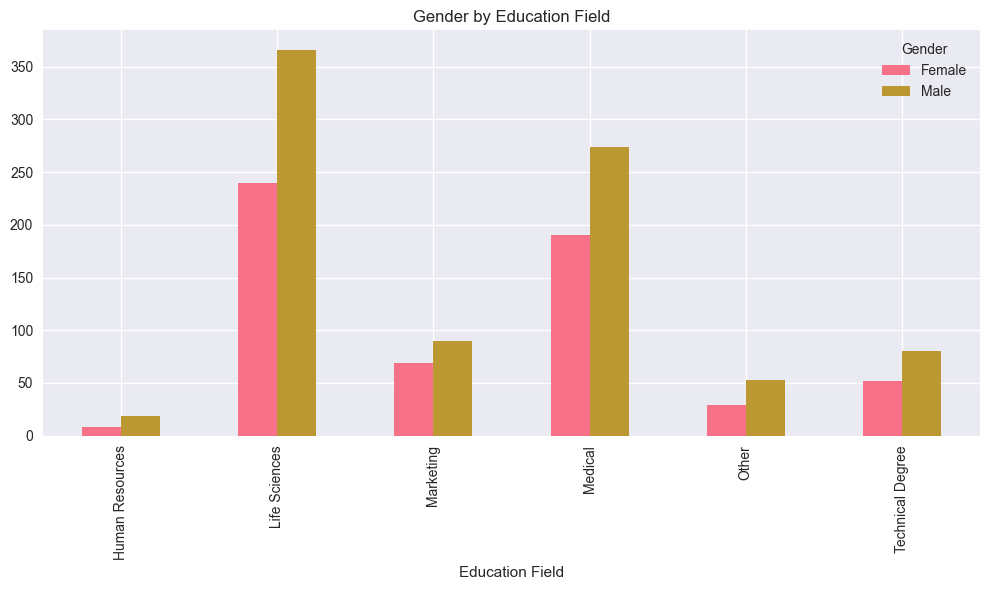

In [54]:
# Education Field
edu_gender = pd.crosstab(df_vis['Education Field'], df_vis['Gender'])
edu_gender.plot(kind='bar', figsize=(10,6))
plt.title("Gender by Education Field")
plt.tight_layout()
plt.savefig("charts/edu_gender.png")
plt.show()

## Task 9: Tenure Prediction

In [55]:
tenure_features = ['Years In Current Role', 'Years With Curr Manager', 
                   'Job Satisfaction', 'Work Life Balance', 'Age']

X = df[tenure_features]
y = df['Years At Company']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
tenure_model = LinearRegression()
tenure_model.fit(X_train, y_train)

LinearRegression()

In [57]:
r2 = r2_score(y_test, tenure_model.predict(X_test))
print(f"Tenure R²: {r2:.3f}")

Tenure R²: 0.698


In [58]:
joblib.dump(tenure_model, "tenure_model.pkl")

['tenure_model.pkl']

## Task 10: Training Effectiveness Evaluation

In [59]:
# Simulate "post-training" improvement
df['Perf_Improvement'] = df['Performance Rating'] - 3  # Assuming 3 is baseline

train_features = ['Training Times Last Year', 'Job Level', 'Job Involvement', 
                  'Years At Company']

X = df[train_features]
y = df['Perf_Improvement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
train_model = LinearRegression()
train_model.fit(X_train, y_train)

LinearRegression()

In [61]:
r2 = r2_score(y_test, train_model.predict(X_test))
print(f"Training Impact R²: {r2:.3f}")

Training Impact R²: -0.009


In [62]:
joblib.dump(train_model, "train_effect_model.pkl")

['train_effect_model.pkl']

## Save Encoders & Summary

In [63]:
# Save label encoders
with open("le_dict.pkl", "wb") as f:
    pickle.dump(le_dict, f)

# KPI Summary
kpi = {
    'Total_Employees': len(df),
    'Attrition_Rate': f"{df['Attrition'].mean()*100:.1f}%",
    'Avg_Salary': f"${df['Monthly Income'].mean():,.0f}",
    'Avg_Tenure': f"{df['Years At Company'].mean():.1f} yrs",
    'Overtime_Rate': f"{df['High_OverTime'].mean()*100:.1f}%",
    'Avg_Job_Satisfaction': f"{df['Job Satisfaction'].mean():.2f}"
}

import json
with open("kpi_summary.json", "w") as f:
    json.dump(kpi, f, indent=2)

print("All 10 tasks completed. Models, charts, and data saved.")
print(kpi)

All 10 tasks completed. Models, charts, and data saved.
{'Total_Employees': 1470, 'Attrition_Rate': '16.1%', 'Avg_Salary': '$6,503', 'Avg_Tenure': '7.0 yrs', 'Overtime_Rate': '28.3%', 'Avg_Job_Satisfaction': '2.73'}


In [64]:
# ONE CELL TO FIX EVERYTHING – RUN THIS NOW
import pickle
import os
import pandas as pd

# --------------------------------------------------------------
# 1. Re-create le_dict safely (even if it was lost or corrupted)
# --------------------------------------------------------------
# If you still have your original dataframe with raw categorical columns:
df_raw = pd.read_csv("HR Data.csv")          # <-- change path if needed
df_raw.columns = df_raw.columns.str.strip()

# List of all categorical columns that need encoding
categorical_cols = df_raw.select_dtypes(include=['object']).columns.tolist()

# Remove columns that are truly constant or irrelevant
cols_to_drop = ['Employee Count', 'Over18', 'Standard Hours', 'Employee Number']
categorical_cols = [c for c in categorical_cols if c not in cols_to_drop]

print("Categorical columns detected:", categorical_cols)

# Re-build the label encoders from scratch
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on the original (string) values
    df_raw[col] = df_raw[col].astype(str)
    le.fit(df_raw[col])
    le_dict[col] = le
    print(f"   → {col}: {len(le.classes_)} unique values")

# --------------------------------------------------------------
# 2. Save the correct le_dict.pkl in the right folder
# --------------------------------------------------------------
os.makedirs("models", exist_ok=True)

with open("models/le_dict.pkl", "wb") as f:
    pickle.dump(le_dict, f)

print("\nSUCCESS: le_dict.pkl recreated and saved!")
print(f"   File size: {os.path.getsize('models/le_dict.pkl'):,} bytes")

# --------------------------------------------------------------
# 3. Quick verification
# --------------------------------------------------------------
with open("models/le_dict.pkl", "rb") as f:
    test = pickle.load(f)

print(f"   Loaded {len(test)} encoders")
print("   Example – Job Role classes:", test['Job Role'].classes_[:10].tolist())

Categorical columns detected: ['Attrition', 'Business Travel', 'CF_age band', 'CF_attrition label', 'Department', 'Education Field', 'emp no', 'Gender', 'Job Role', 'Marital Status', 'Over Time', 'Education']
   → Attrition: 2 unique values
   → Business Travel: 3 unique values
   → CF_age band: 5 unique values
   → CF_attrition label: 2 unique values
   → Department: 3 unique values
   → Education Field: 6 unique values
   → emp no: 1470 unique values
   → Gender: 2 unique values
   → Job Role: 9 unique values
   → Marital Status: 3 unique values
   → Over Time: 2 unique values
   → Education: 5 unique values

SUCCESS: le_dict.pkl recreated and saved!
   File size: 19,825 bytes
   Loaded 12 encoders
   Example – Job Role classes: ['Healthcare Representative', 'Human Resources', 'Laboratory Technician', 'Manager', 'Manufacturing Director', 'Research Director', 'Research Scientist', 'Sales Executive', 'Sales Representative']
